In [14]:
#from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, StratifiedGroupKFold
from sklearn.metrics import balanced_accuracy_score, classification_report, accuracy_score

import numpy as np
import pandas as pd
from sklearn.ensemble import VotingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report


In [15]:
data = pd.read_csv('itamplify_train.csv')
# drop X and track_id columns
columns_to_drop = ['track_name', 'track_id', 'artists', 'album_name', 'X']
data = data.drop(columns=columns_to_drop, axis=1)

train, test = train_test_split(data, 
                                stratify=data['track_genre'],
                                test_size=0.2,
                                random_state=42)

train, val = train_test_split(train,
                                stratify=train['track_genre'],
                                test_size=0.2,
                                random_state=42)


In [4]:
print("---train---")
print(f"observaciones train: {train.size}")
print(train['track_genre'].value_counts(normalize=True))


---train---
observaciones train: 84624
samba          0.117792
techno         0.105124
psych-rock     0.103989
folk           0.092645
disco          0.083570
funk           0.076007
blues          0.072982
hip-hop        0.069200
heavy-metal    0.050482
reggaeton      0.044999
alternative    0.043297
afrobeat       0.041407
country        0.035356
jazz           0.032709
classical      0.030441
Name: track_genre, dtype: float64


In [5]:
print("---val---")
print(f"observaciones train: {val.size}")
print(val['track_genre'].value_counts(normalize=True))


---val---
observaciones train: 21168
samba          0.117914
techno         0.105064
psych-rock     0.103553
folk           0.092971
disco          0.083900
funk           0.076342
blues          0.072562
hip-hop        0.069539
heavy-metal    0.050642
reggaeton      0.045351
alternative    0.043084
afrobeat       0.040816
country        0.035525
jazz           0.032502
classical      0.030234
Name: track_genre, dtype: float64


In [6]:
print("---test---")
print(f"observaciones test: {test.size}")
print(test['track_genre'].value_counts(normalize=True))

---test---
observaciones test: 26464
samba          0.117896
techno         0.105200
psych-rock     0.103990
folk           0.092503
disco          0.084039
funk           0.076179
blues          0.072551
hip-hop        0.069528
heavy-metal    0.050786
reggaeton      0.044740
alternative    0.043531
afrobeat       0.041112
country        0.035067
jazz           0.032648
classical      0.030230
Name: track_genre, dtype: float64


In [7]:
def encode_genres(data):
    """
    Converts the 'track_genre' column to one-hot encoded format.

    Parameters:
    - data (pd.DataFrame): DataFrame containing the 'track_genre' column.

    Returns:
    - pd.DataFrame: Modified DataFrame with 'track_genre' replaced by one-hot encoded columns.
    """
    # Create one-hot encoded variables
    genre_dummies = pd.get_dummies(data['track_genre'], prefix='genre')
    
    # Drop the original 'track_genre' column
    data = data.drop('track_genre', axis=1)
    
    # Concatenate the original DataFrame and the new one-hot encoded DataFrame
    data_encoded = pd.concat([data, genre_dummies], axis=1)
    
    return data_encoded


In [8]:
categorical_features = ['key', 'time_signature']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)],
    remainder='passthrough')


In [30]:
X_train = train.drop('track_genre', axis=1)
y_train = train['track_genre']
X_val = val.drop('track_genre', axis=1)
y_val = val['track_genre']


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2655
[LightGBM] [Info] Number of data points in the train set: 5289, number of used features: 29
[LightGBM] [Info] Start training from score -3.184313
[LightGBM] [Info] Start training from score -3.139662
[LightGBM] [Info] Start training from score -2.617547
[LightGBM] [Info] Start training from score -3.491980
[LightGBM] [Info] Start training from score -3.342276
[LightGBM] [Info] Start training from score -2.482075
[LightGBM] [Info] Start training from score -2.378979
[LightGBM] [Info] Start training from score -2.576932
[LightGBM] [Info] Start training from score -2.986136
[LightGBM] [Info] Start training from score -2.670751
[LightGBM] [Info] Start training from score -3.420093
[LightGBM] [Info] Start training from score -2.263466
[LightGBM] [Info] Start training from score -3.101114
[LightGBM]

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['key', 'time_signature'])])),
                ('classifier',
                 VotingClassifier(estimators=[('lgb',
                                               LGBMClassifier(learning_rate=0.05)),
                                              ('xgb',
                                               XGBClassifier(base_score=None,
                                                             booster=None,
                                                             callbacks=None,
                                                             colsample_bylevel=None,
                                                             colsample_byn...
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             learning_rate=0.05,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=None,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=100,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             random_state=None, ...))],
                                  voting='soft'))])

In [31]:

# Set up the models and ensemble
lgb_model = LGBMClassifier(n_estimators=100, learning_rate=0.05)
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.05)

ensemble = VotingClassifier(
    estimators=[('lgb', lgb_model), ('xgb', xgb_model)],
    voting='soft')

# Create a pipeline with preprocessing and ensemble
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', ensemble)])

# Fit the pipeline
pipeline.fit(X_train, y_train)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000969 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2655
[LightGBM] [Info] Number of data points in the train set: 5289, number of used features: 29
[LightGBM] [Info] Start training from score -3.184313
[LightGBM] [Info] Start training from score -3.139662
[LightGBM] [Info] Start training from score -2.617547
[LightGBM] [Info] Start training from score -3.491980
[LightGBM] [Info] Start training from score -3.342276
[LightGBM] [Info] Start training from score -2.482075
[LightGBM] [Info] Start training from score -2.378979
[LightGBM] [Info] Start training from score -2.576932
[LightGBM] [Info] Start training from score -2.986136
[LightGBM] [Info] Start training from score -2.670751
[LightGBM] [Info] Start training from score -3.420093
[LightGBM] [Info] Start training from score -2.263466
[LightGBM] [Info] Start training from score -3.101114
[LightGBM]

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['key', 'time_signature'])])),
                ('classifier',
                 VotingClassifier(estimators=[('lgb',
                                               LGBMClassifier(learning_rate=0.05)),
                                              ('xgb',
                                               XGBClassifier(base_score=None,
                                                             booster=None,
                                                             callbacks=None,
                                                             colsample_bylevel=None,
                                                             colsample_byn...
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             learning_rate=0.05,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=None,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=100,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             random_state=None, ...))],
                                  voting='soft'))])

In [12]:

# Predict and evaluate
y_pred = pipeline.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
balanced_accuracy = balanced_accuracy_score(y_val, y_pred)
class_report = classification_report(y_val, y_pred)

print("Accuracy:", accuracy)
print("Balanced Accuracy:", balanced_accuracy)
print("Classification Report:\n", class_report)

Accuracy: 0.6069538926681783
Balanced Accuracy: 0.5527723511995127
Classification Report:
               precision    recall  f1-score   support

    afrobeat       0.47      0.33      0.39        54
 alternative       0.41      0.42      0.42        57
       blues       0.38      0.24      0.29        96
   classical       0.62      0.60      0.61        40
     country       0.33      0.26      0.29        47
       disco       0.55      0.58      0.56       111
        folk       0.51      0.56      0.53       123
        funk       0.72      0.74      0.73       101
 heavy-metal       0.71      0.82      0.76        67
     hip-hop       0.60      0.78      0.68        92
        jazz       0.32      0.16      0.22        43
  psych-rock       0.56      0.66      0.60       137
   reggaeton       0.68      0.53      0.60        60
       samba       0.78      0.87      0.82       156
      techno       0.78      0.73      0.76       139

    accuracy                           0.61

In [17]:
lgb_model = LGBMClassifier(n_estimators=100, learning_rate=0.05)
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.05)
cat_model = CatBoostClassifier(verbose=0, n_estimators=100, learning_rate=0.05)  # verbose=0 to keep output clean

ensemble = VotingClassifier(
    estimators=[('lgb', lgb_model), ('xgb', xgb_model), ('cat', cat_model)],
    voting='soft')

# Create a pipeline with preprocessing and ensemble
pipeline2 = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', ensemble)])

# Fit the pipeline
pipeline2.fit(X_train, y_train)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000913 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2655
[LightGBM] [Info] Number of data points in the train set: 5289, number of used features: 29
[LightGBM] [Info] Start training from score -3.184313
[LightGBM] [Info] Start training from score -3.139662
[LightGBM] [Info] Start training from score -2.617547
[LightGBM] [Info] Start training from score -3.491980
[LightGBM] [Info] Start training from score -3.342276
[LightGBM] [Info] Start training from score -2.482075
[LightGBM] [Info] Start training from score -2.378979
[LightGBM] [Info] Start training from score -2.576932
[LightGBM] [Info] Start training from score -2.986136
[LightGBM] [Info] Start training from score -2.670751
[LightGBM] [Info] Start training from score -3.420093
[LightGBM] [Info] Start training from score -2.263466
[LightGBM] [Info] Start training from score -3.101114
[LightGBM]

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['key', 'time_signature'])])),
                ('classifier',
                 VotingClassifier(estimators=[('lgb',
                                               LGBMClassifier(learning_rate=0.05)),
                                              ('xgb',
                                               XGBClassifier(base_score=None,
                                                             booster=None,
                                                             callbacks=None,
                                                             colsample_bylevel=None,
                                                             colsample_byn...
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=None,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=100,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             random_state=None, ...)),
                                              ('cat',
                                               <catboost.core.CatBoostClassifier object at 0x000001BA20DAFE50>)],
                                  voting='soft'))])

In [18]:

# Predict and evaluate
y_pred = pipeline.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
balanced_accuracy = balanced_accuracy_score(y_val, y_pred)
class_report = classification_report(y_val, y_pred)

print("Accuracy:", accuracy)
print("Balanced Accuracy:", balanced_accuracy)
print("Classification Report:\n", class_report)

Accuracy: 0.6069538926681783
Balanced Accuracy: 0.5527723511995127
Classification Report:
               precision    recall  f1-score   support

    afrobeat       0.47      0.33      0.39        54
 alternative       0.41      0.42      0.42        57
       blues       0.38      0.24      0.29        96
   classical       0.62      0.60      0.61        40
     country       0.33      0.26      0.29        47
       disco       0.55      0.58      0.56       111
        folk       0.51      0.56      0.53       123
        funk       0.72      0.74      0.73       101
 heavy-metal       0.71      0.82      0.76        67
     hip-hop       0.60      0.78      0.68        92
        jazz       0.32      0.16      0.22        43
  psych-rock       0.56      0.66      0.60       137
   reggaeton       0.68      0.53      0.60        60
       samba       0.78      0.87      0.82       156
      techno       0.78      0.73      0.76       139

    accuracy                           0.61

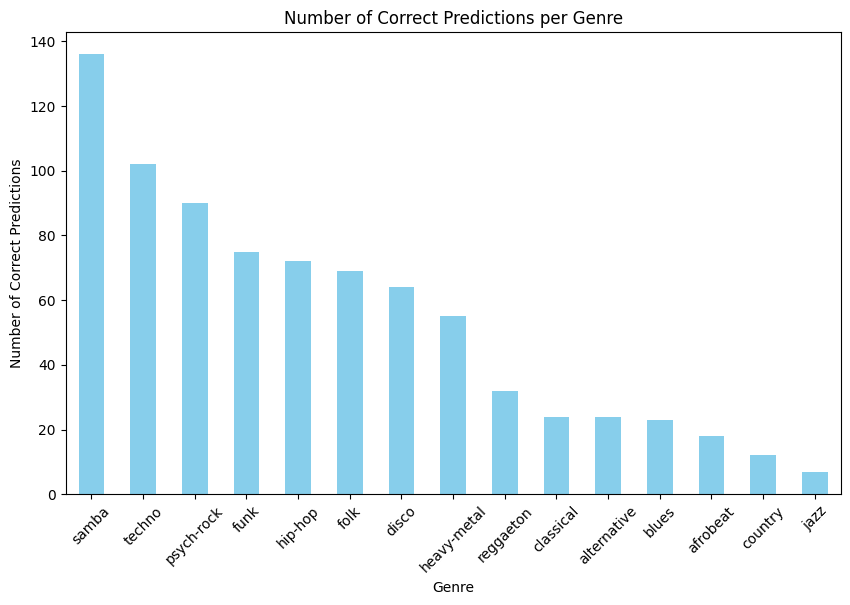

In [22]:
import matplotlib.pyplot as plt

matches = np.where(y_pred == y_val)[0]

# Get the correctly predicted genres
correct_genres = y_val.iloc[matches]

# Count the number of correct predictions per genre
genre_counts = correct_genres.value_counts()

# Plotting the results
plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Correct Predictions per Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Correct Predictions')
plt.xticks(rotation=45)
plt.show()

In [ ]:

true_positives = test.iloc[matches[:10]]  
true_positives

In [34]:
# Define a DataFrame for a single song with adjusted features for the hypothetical "Pop" classification
song_data = pd.DataFrame({
    "X": [12345],  # Arbitrary example index
    "track_id": ["track_00123"],  # Example track ID
    "artists": ["Example Artist"],  # Example artist name
    "album_name": ["Example Album"],  # Example album name
    "track_name": ["Example Track"],  # Example track name
    "popularity": [65],  # Set to a plausible popularity
    "duration_ms": [210000],  # Set to a plausible duration in milliseconds
    "explicit": [0],  # Assume the track is not explicit
    "danceability": [0.73],  # High danceability
    "energy": [0.7],  # Typical energy for a pop track
    "key": [5],  # A common key
    "loudness": [-5],  # Relatively loud
    "mode": [1],  # Major mode, common in pop music
    "speechiness": [0.05],  # Not too speechy
    "acousticness": [0.1],  # Lower than average acousticness
    "instrumentalness": [0.001],  # Minimal instrumentalness
    "liveness": [0.1],  # Not very live
    "valence": [0.75],  # High valence for cheerful vibe
    "tempo": [120],  # Typical tempo
    "time_signature": [4],  # Most common time signature
    "track_genre": ["Pop"]  # Assume the target genre is Pop
}, index=[0])

(song_data)

,X,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,12345,track_00123,Example Artist,Example Album,Example Track,65,210000,0,0.73,0.7,...,-5,1,0.05,0.1,0.001,0.1,0.75,120,4,Pop


In [36]:
# save song_data to a csv file
song_data.to_csv('remix.csv', index=False)

In [35]:
predicted_genre = pipeline.predict(song_data)

print("Predicted Genre:", predicted_genre)

Predicted Genre: ['disco']


In [26]:
predicted_genre = pipeline2.predict(song_data)

print("Predicted Genre:", predicted_genre)

Predicted Genre: ['disco']


In [32]:
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, use_label_encoder=False, eval_metric='mlogloss')

# Create a pipeline with preprocessing and XGBoost classifier
pipeline_XGB = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', xgb_model)])

# Fit the pipeline on the training data
pipeline_XGB.fit(X_train, y_train)

print("Predicted Genre:", pipeline_XGB.predict(song_data))


ValueError: Invalid classes inferred from unique values of `y`.  Expected: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14], got ['afrobeat' 'alternative' 'blues' 'classical' 'country' 'disco' 'folk'
 'funk' 'heavy-metal' 'hip-hop' 'jazz' 'psych-rock' 'reggaeton' 'samba'
 'techno']